In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd//content/drive/MyDrive/lung cancer

/content/drive/MyDrive/lung cancer


In [ ]:
ls

'Bengin cases'/                        'Malignant cases'/
'IQ-OTH_NCCD lung cancer dataset.txt'  'Normal cases'/
 lung_cancer_detection.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [ ]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=15
CHANNELS=3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/lung cancer",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1097 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
len(dataset)

18

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 ...

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]], shape=(256, 256, 3), dtype=float32)
[0 1 2 1 1 1 1 0 2 2 1 0 1 0 0 2 1 1 2 1 1 2 1 0 2 2 1 1 1 1 2 2 2 1 2 1 1
 2 1 1 2 2 1 2 1 2 0 2 2 2 1 0 1 1 2 0 1 1 0 0 2 1]


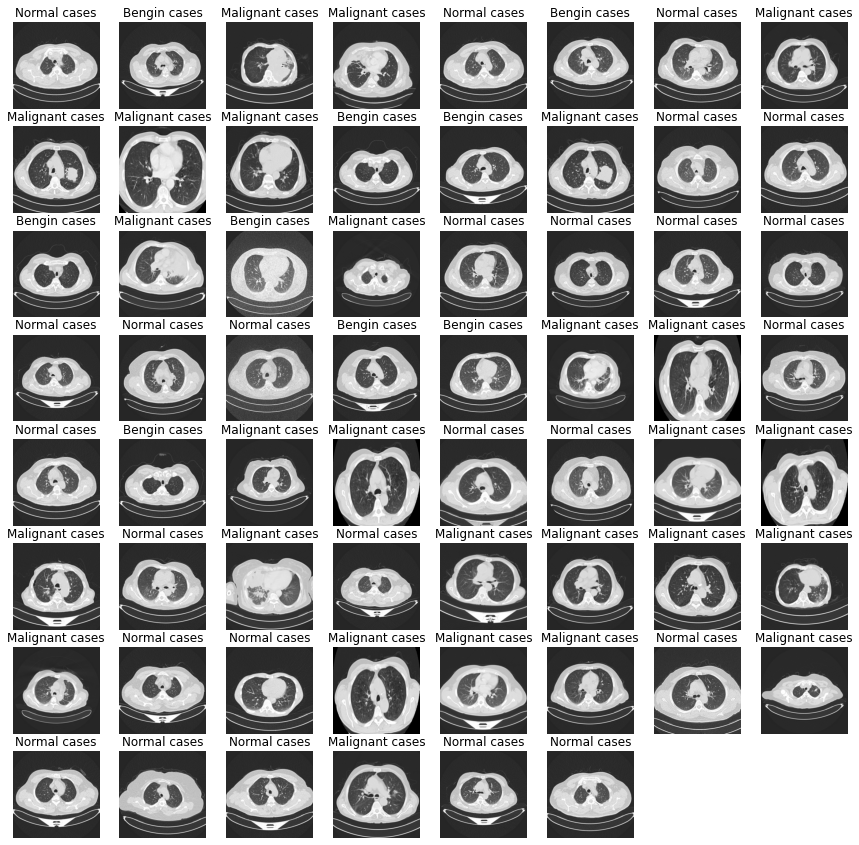

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (62, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (62, 60, 60, 64)         

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/15
14/14 [==============================] - 121s 6s/step - loss: 1.0012 - accuracy: 0.4853 - val_loss: 0.8900 - val_accuracy: 0.5161
Epoch 2/15
14/14 [==============================] - 83s 6s/step - loss: 0.9666 - accuracy: 0.5006 - val_loss: 0.8328 - val_accuracy: 0.5161
Epoch 3/15
14/14 [==============================] - 78s 6s/step - loss: 0.9578 - accuracy: 0.5194 - val_loss: 0.8314 - val_accuracy: 0.5161
Epoch 4/15
14/14 [==============================] - 78s 6s/step - loss: 0.9082 - accuracy: 0.5571 - val_loss: 0.7185 - val_accuracy: 0.7419
Epoch 5/15
14/14 [==============================] - 79s 6s/step - loss: 0.7602 - accuracy: 0.6914 - val_loss: 0.5147 - val_accuracy: 0.8226
Epoch 6/15
14/14 [==============================] - 79s 6s/step - loss: 0.6456 - accuracy: 0.7468 - val_loss: 0.4043 - val_accuracy: 0.8710
Epoch 7/15
14/14 [==============================] - 79s 6s/step - loss: 0.5023 - accuracy: 0.8068 - val_loss: 0.3435 - val_accuracy: 0.9194
Epoch 8/15
14/14 [=

In [ ]:
model.evaluate(test_ds)

3/3 [==============================] - 14s 2s/step - loss: 0.1675 - accuracy: 0.9355


[0.1675499975681305, 0.9354838728904724]

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

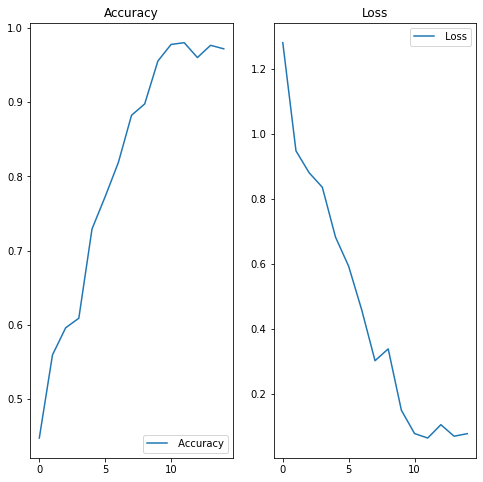

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

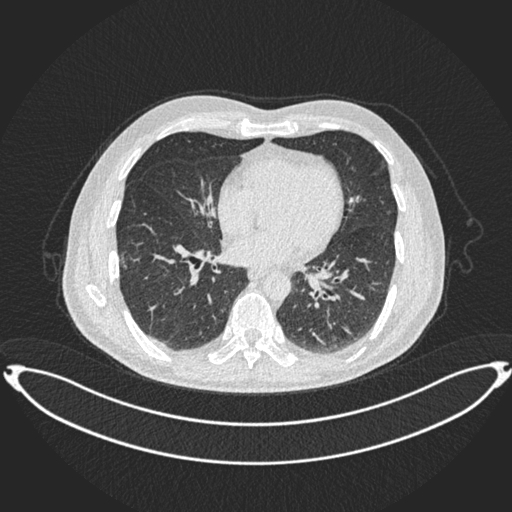

In [ ]:
image_path = "/content/drive/MyDrive/lung cancer/Bengin cases/Bengin case (10).jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [ ]:
pred = model.predict(scaled_img)

1/1 [==============================] - 1s 937ms/step


In [ ]:
output = class_names[np.argmax(pred)]
output

'Bengin cases'

In [ ]:
model.save("lung_cancer_detection.h5")